# Apply pixel classifier on all images in a folder,  create corresponding mask

In [2]:
from scipy import ndimage
from skimage.morphology import binary_erosion
import sys

from sklearn.ensemble import RandomForestClassifier
import glob
import os
import cv2
import pickle as pkl

from csbdeep.utils import normalize
import numpy as np
import skimage
from skimage.morphology import square
import scipy
from skimage.segmentation import expand_labels
import matplotlib.pyplot as plt
import pandas as pd
sys.path.append(os.path.realpath('/Users/max/Desktop/Scripts_for_max/'))
from semantic_segmentation import init_VGG16_pyramid, fd_VGG16_pyramid

ImportError: dlopen(/Users/max/opt/anaconda3/envs/tf/lib/python3.9/site-packages/cv2/cv2.cpython-39-darwin.so, 2): Library not loaded: /usr/local/opt/openssl/lib/libssl.1.0.0.dylib
  Referenced from: /usr/local/opt/ffmpeg/lib/libavformat.58.dylib
  Reason: image not found

In [12]:
file

NameError: name 'file' is not defined

In [6]:
def spot_mask_from_labels(labels):
    '''takes label mask, shrinks objects and subtracts from original image.'''
    stim_width = 10
    footprint = np.ones((stim_width,stim_width))
    labels_b = labels>0
    labels_b_ero = binary_erosion(labels_b,footprint)
    labels_b_sub = np.logical_xor(labels_b,labels_b_ero)
    labels_b_sub = labels_b_sub.astype('uint8')
    labels_sub = np.multiply(labels_b_sub,labels)
    
    df = pd.DataFrame()
    props = skimage.measure.regionprops(labels)
    for prop in props[:]:
        df_spot = pd.DataFrame({'cell_label': [prop.label],'cell_x': [prop.centroid[0]], 'cell_y':[prop.centroid[1]], 'cell_area': [prop.area],'stim_width':[stim_width]})
        df = df.append(df_spot)

    return labels_b_sub,df

def frame_to_labels(frame):
    f_h2b = frame[1,:,:].copy()
    f_h2b_scaled = normalize(f_h2b, 5,95)
    features = fd_VGG16_pyramid(f_h2b_scaled,models,shapes)
    to_predict = features.reshape(np.shape(features)[0]*np.shape(features)[1],np.shape(features)[2])
    prediction_list = clf.predict_proba(to_predict)[:,0]
    prediction_img = np.reshape(prediction_list, f_h2b_scaled.shape)
    #now run watershed on segmentaion, using no seed
    prediction_img = prediction_img>0.5
    prediction_img = skimage.morphology.erosion(prediction_img, square(5))
    prediction_img = skimage.morphology.remove_small_objects(prediction_img, min_size = 100**2)
    prediction_img = scipy.ndimage.morphology.binary_fill_holes(prediction_img)
        
    #labels = skimage.segmentation.watershed(-distance_img, mask = prediction_img)#, mask=prediction_img>0.5)
    labels = skimage.segmentation.watershed(~prediction_img, mask = prediction_img)

    return labels

### Import the classifier you want to use

In [ ]:
file = open("F:\\Max\\micromanager\\calibration\\classifier_max_2021-10-15_DLC1.pkl", "rb")
clf = pkl.load(file)
file.close()

In [2]:
file = open("F:\\Max\\micromanager\\calibration\\classifier_max_2021-10-15_DLC1.pkl", "wb")
pkl.dump(clf, file)

file.close()

NameError: name 'pkl' is not defined

### Set input and output folders

In [3]:
input_folder = '/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_11_late/cp.out1/output/'
output_folder_segmentation = '/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_11_late/cp.out1/output/output_segmentation//'
output_folder_mask = '/Volumes/imaging.data/Max/REF52/DLC_1/FRET/FRET_11_late/cp.out1/output/output_mask/'

### Search images

In [4]:
filenames = sorted(glob.glob(os.path.join(input_folder,'*.TIF')))
print(f'Found {len(filenames)} input files.')
print(f'Last file: {filenames[-2]}')
raw = io.imread(filenames[-1])

NameError: name 'glob' is not defined

In [ ]:
project_path = 'Z:\\lhinder\\data\\rtm_mm_data\\exp_63\\'
fov = 0
raw = io.imread(filenames[-1])
frame = raw
norm_min = 5
norm_max = 95
f_h2b = frame[1,:,:].copy()
annotation_frame = normalize(f_h2b, norm_min,norm_max)

In [ ]:
#create the classifier
clf = RandomForestClassifier(random_state=0)

# create feature extractor and apply 
#shapes = [(1024,1024),(512,512),(256,256),(128,128),(64,64)]
shapes = [(512,512),(64,64),(32,32)]
models = init_VGG16_pyramid(shapes)
features = fd_VGG16_pyramid(annotation_frame,models,shapes)


@magicgui(call_button='train classifier')
def clf_widget():
    #run everytime the train button is pressed
    #extract the labels
    annotations = np.array(labels_layer.data)
    X,y = annotations_to_tensor(features,annotations)
    clf.fit(X, y) #train the classifier on the new labels
    #now predict the rest of the image with the new clf
    to_predict = features.reshape(np.shape(features)[0]*np.shape(features)[1],np.shape(features)[2])
    prediction_list = clf.predict_proba(to_predict)[:,0]
    prediction_img = np.reshape(prediction_list, annotation_frame.shape)
    
    #display the new prediciton
    prediction_layer.visible = True
    prediction_layer.data = prediction_img
    return clf

def annotations_to_tensor(feature_matrix,mask):
    #feature matrix dim: [x,y,nb_features]
    #possible mask elements: 0: not annotated, int[1,2]: class annotation
    y_labels=[] #where class labels are stored
    X_features=[] #where feature vectors are stored
    for x,y in np.argwhere(mask!=0):
        y_labels.append(mask[x,y])
        X_features.append(feature_matrix[x,y,:])
    #turn list into np array
    X_features = np.asarray(X_features)
    return X_features,y_labels

viewer = napari.view_image(annotation_frame, name="My Image")


labels_layer = viewer.add_labels(np.zeros_like(annotation_frame).astype(int), seed = 0)
viewer.window.add_dock_widget(clf_widget)
prediction_layer = viewer.add_image(np.zeros_like(annotation_frame),colormap='PiYG')
prediction_layer.visible = False
prediction_layer.name = "Classifier prediction"
napari.run()

### Run the segmentation on all images

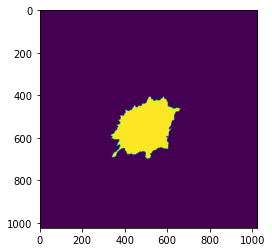

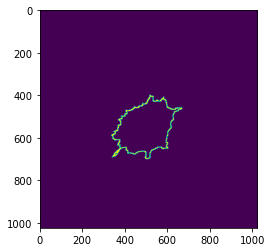

In [133]:
shapes = [(512,512),(64,64),(32,32)]
models = init_VGG16_pyramid(shapes)
frame_segmented = frame_to_labels(raw)
for i, filename in enumerate(filenames):
    frame = io.imread(filename)
    # if input image has multiple channels, select the correct one here:
    #frame = frame[channel_nb,:,:] #where channel_nb is the channel you want to segment on
    frame_segmented = frame_to_labels(frame)
    frame_mask, table = spot_mask_from_labels(frame_segmented)
    if i == 0:
        plt.imshow(frame_segmented)
        plt.show()
        plt.imshow(mask)
        plt.show()
    io.imsave(output_folder_mask + os.path.basename(filename), frame_mask, check_contrast=False)
    io.imsave(output_folder_segmentation + os.path.basename(filename), frame_segmented, check_contrast=False)